# Function Testing Notebook - Joseph

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [1]:
import os
import sys
from pathlib import Path
import time
import tempfile
import logging

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import mne
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, LocalCluster

In [2]:
from pythoneeg import core
from pythoneeg import visualization
from pythoneeg import constants

print(core.__all__)
# print(visualization.__all__)
# print(dir(constants))

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['DDFBinaryMetadata', 'LongRecordingOrganizer', 'convert_ddfcolbin_to_ddfrowbin', 'convert_ddfrowbin_to_si', 'convert_units_to_multiplier', 'convert_colpath_to_rowpath', 'filepath_to_index', 'is_day', 'set_temp_directory', 'get_temp_directory', 'parse_path_to_animalday', 'parse_str_to_genotype', 'parse_str_to_animal', 'parse_str_to_day', 'parse_chname_to_abbrev', 'nanaverage', 'LongRecordingAnalyzer', 'MountainSortAnalyzer', 'FragmentAnalyzer', '_log_transform']


In [3]:
tempdir = Path('../../tmp').resolve()
print(tempdir)
core.set_temp_directory(tempdir)

/mnt/isilon/marsh_single_unit/PythonEEG/tmp


In [4]:
data_folder = Path('./test-data').resolve()
lrec = core.LongRecordingOrganizer(base_folder_path= data_folder / 'A10 KO 12_13_2023',
                                    truncate=3)
lrec.convert_colbins_to_rowbins(overwrite=False)
lrec.convert_rowbins_to_rec()

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/core/core.py:204: UserWarning: LongRecording will be truncated to the first 3 files
  warnings.warn(f"LongRecording will be truncated to the first {self.n_truncate} files")


In [5]:
Path('./test-wars/A5').resolve()

PosixPath('/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/tests/test-wars/A5')

In [6]:
# Set up logger with detailed formatting
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG, stream=sys.stdout, force=True)
logger = logging.getLogger()


In [7]:
cluster = LocalCluster()
display(cluster)

2025-06-06 15:09:10,075 - DEBUG - Using selector: EpollSelector


LocalCluster(1df97dd5, 'tcp://127.0.0.1:35573', workers=4, threads=4, memory=5.78 GiB)

In [ ]:
# %%script true
# animal_ids = ['A5', 'A10', 'F22', 'G25', 'G26', 'N21', 'N22', 'N23', 'N24', 'N25']
# animal_ids = ['A5', 'A10']
animal_ids = []
# animal_ids = ['A5']
# animal_ids = ['A10']
# animal_ids = ['F22']
# animal_ids = ['G25']
base_folder = Path('./test-data').resolve()
# base_folder = Path('/mnt/isilon/marsh_single_unit/PythonEEG Data Bins').resolve()
for animal_id in animal_ids:
    ao = visualization.AnimalOrganizer(base_folder, animal_id, mode="concat", assume_from_number=True, truncate=False)
    ao.convert_colbins_to_rowbins(overwrite=False)
    ao.convert_rowbins_to_rec() # parallelization breaks if not enough memory

    ao.compute_bad_channels()

    with Client(cluster) as client:
        # client.upload_file(str(packageroot / 'pythoneeg.zip'))
        display(client)
        print("running war")
        # ao.convert_rowbins_to_rec(multiprocess_mode='dask') # paralleization breaks if not enough memory
        war = ao.compute_windowed_analysis(['all'], multiprocess_mode='serial')
    #     war.save_pickle_and_json(Path(f'./test-wars-full/{animal_id}').resolve())

    # with Client(cluster) as client:
    #     client.upload_file(str(packageroot / 'pythoneeg.zip'))
    #     display(client)
    #     print("running sar")
    #     sar = ao.compute_spike_analysis(multiprocess_mode='dask')

In [ ]:
war = visualization.WindowAnalysisResult.load_pickle_and_json(Path('/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/tests/test-wars-sox5-2/011622_cohort4_group4_3mice_MMutOLD_FMUT_FMUT_FWT FMUT(2)').resolve())

In [ ]:
# war.aggregate_time_windows()

In [14]:
display(war.get_result(['all'], allow_missing=True).head(3))
display(war.get_result(['all'], allow_missing=True).tail(3))

,index,animalday,animal,day,genotype,duration,endfile,timestamp,isday,rms,...,logampvar,logpsdtotal,lognspike,psdband,psdfrac,logpsdband,logpsdfrac,cohere,pcorr,psd
0,0,F22 KO Dec-12-2023,F22,2023-12-12,KO,4.0,None,2023-12-12 12:49:13.560,True,"[324.54126, 123.114975, 89.73853, 199.99457, 3...",...,NaN,NaN,NaN,"{'delta': [2371.695324738739, 3296.14610609939...","{'delta': [0.7929006132423677, 0.3413720167377...",NaN,NaN,"{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."
1,1,F22 KO Dec-12-2023,F22,2023-12-12,KO,4.0,None,2023-12-12 12:49:17.560,True,"[33.98209, 98.85394, 73.50655, 72.370285, 407....",...,NaN,NaN,NaN,"{'delta': [190.0428130962193, 1800.43295303487...","{'delta': [0.3076867382203503, 0.2054261960346...",NaN,NaN,"{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."
2,2,F22 KO Dec-12-2023,F22,2023-12-12,KO,4.0,None,2023-12-12 12:49:21.560,True,"[39.47056, 100.14916, 70.84106, 86.55565, 620....",...,NaN,NaN,NaN,"{'delta': [306.9726448654066, 2821.06366983401...","{'delta': [0.3795687977069391, 0.3635538527127...",NaN,NaN,"{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."


,index,animalday,animal,day,genotype,duration,endfile,timestamp,isday,rms,...,logampvar,logpsdtotal,lognspike,psdband,psdfrac,logpsdband,logpsdfrac,cohere,pcorr,psd
114,114,F22 KO Dec-12-2023,F22,2023-12-12,KO,4.00,None,2023-12-12 12:56:49.560,True,"[46.396965, 104.66628, 75.38896, 89.61717, 905...",...,NaN,NaN,NaN,"{'delta': [812.9316262703276, 4314.63730938970...","{'delta': [0.5229946638648364, 0.4800253549585...",NaN,NaN,"{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."
115,115,F22 KO Dec-12-2023,F22,2023-12-12,KO,4.00,None,2023-12-12 12:56:53.560,True,"[62.890266, 107.152565, 84.10927, 118.317406, ...",...,NaN,NaN,NaN,"{'delta': [680.0115522459794, 1574.61762841435...","{'delta': [0.4683691816276278, 0.2450954402217...",NaN,NaN,"{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."
116,116,F22 KO Dec-12-2023,F22,2023-12-12,KO,2.44,None,2023-12-12 12:56:57.560,True,"[95.08962, 215.0994, 72.57969, 230.13222, 1297...",...,NaN,NaN,NaN,"{'delta': [2341.4462564962714, 10688.943530760...","{'delta': [0.7706995397572795, 0.6873029804988...",NaN,NaN,"{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."


In [15]:
print(war.bad_channels_dict)
# war.get_filter_reject_channels_by_recording_session()
war.filter_all()

{}
2025-06-06 15:12:28,147 - INFO - get_filter_logrms_range:	filtered 13/1170
2025-06-06 15:12:28,149 - INFO - get_filter_high_rms:	filtered 114/1170
2025-06-06 15:12:28,151 - INFO - get_filter_low_rms:	filtered 1/1170
2025-06-06 15:12:28,154 - INFO - get_filter_high_beta:	filtered 40/1170
2025-06-06 15:12:28,155 - WARNING - No bad channels specified for recording session F22 KO Dec-12-2023
2025-06-06 15:12:28,156 - INFO - get_filter_reject_channels_by_recording_session:	filtered 0/1170
2025-06-06 15:12:28,157 - DEBUG - filt_bool_all.shape: (117, 10)
2025-06-06 15:12:28,158 - INFO - Filtering rms
2025-06-06 15:12:28,161 - INFO - Filtering ampvar
2025-06-06 15:12:28,162 - INFO - Filtering psdtotal
2025-06-06 15:12:28,165 - INFO - Filtering psdslope
2025-06-06 15:12:28,168 - INFO - Skipping nspike because it is not in result
2025-06-06 15:12:28,168 - INFO - Skipping logrms because it is not in result
2025-06-06 15:12:28,169 - INFO - Skipping logampvar because it is not in result
2025-06-

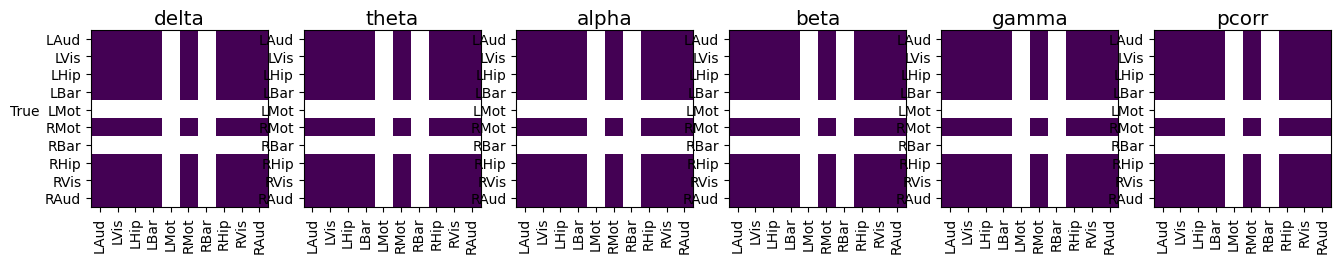

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/animal.py:216: RuntimeWarning: Mean of empty slice
  data_Z = X - np.nanmean(X, axis=axis, keepdims=True)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/animal.py:216: RuntimeWarning: Mean of empty slice
  data_Z = X - np.nanmean(X, axis=axis, keepdims=True)


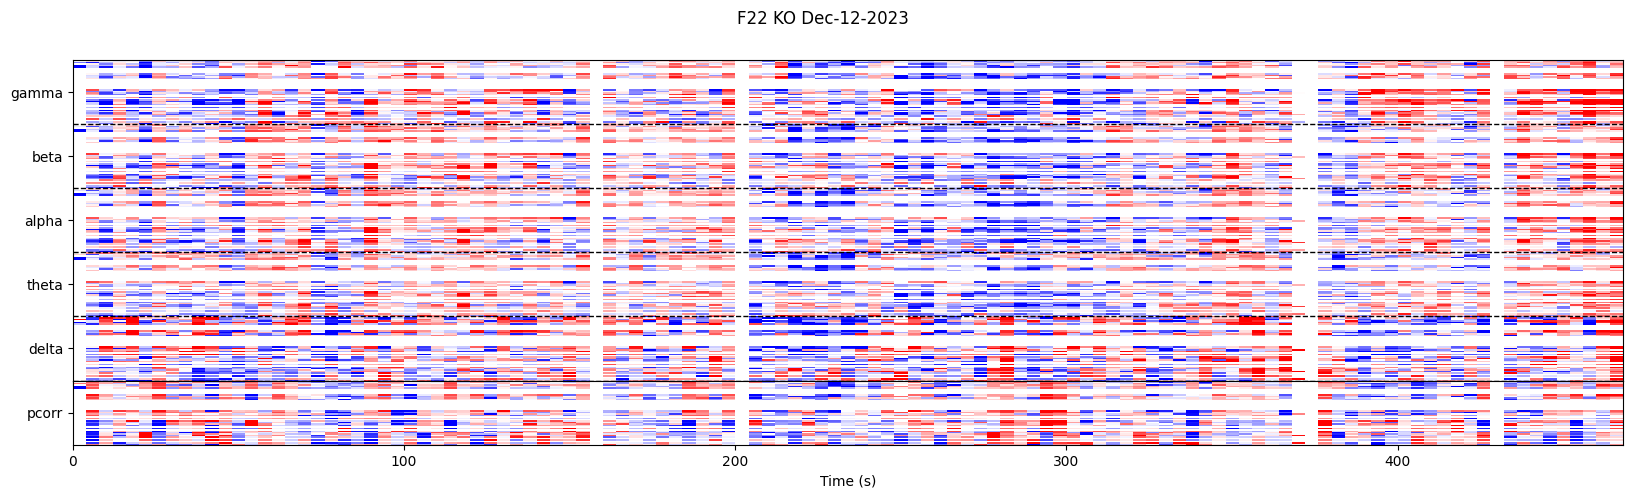

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/animal.py:318: RuntimeWarning: divide by zero encountered in log10
  ax[0, i].plot(freqs, 10**(b + m * np.log10(freqs)), c=f'C{j}', alpha=0.75)


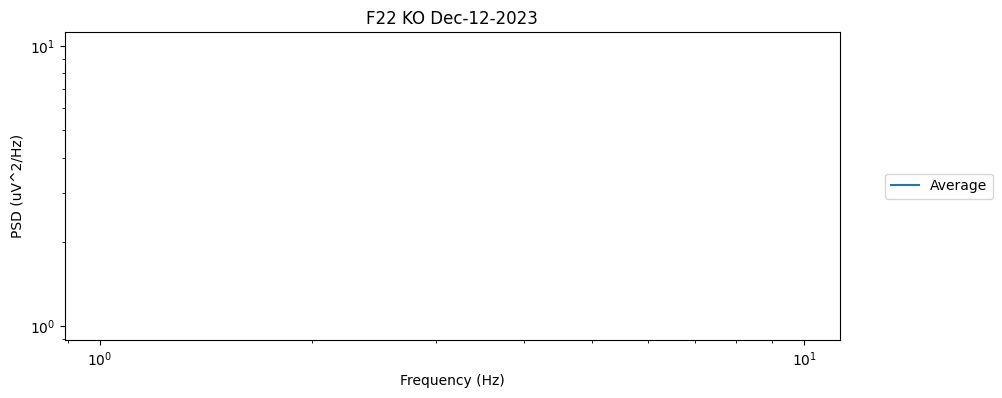

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/animal.py:335: RuntimeWarning: Mean of empty slice
  psd = np.nanmean(psd, axis=-1).transpose()


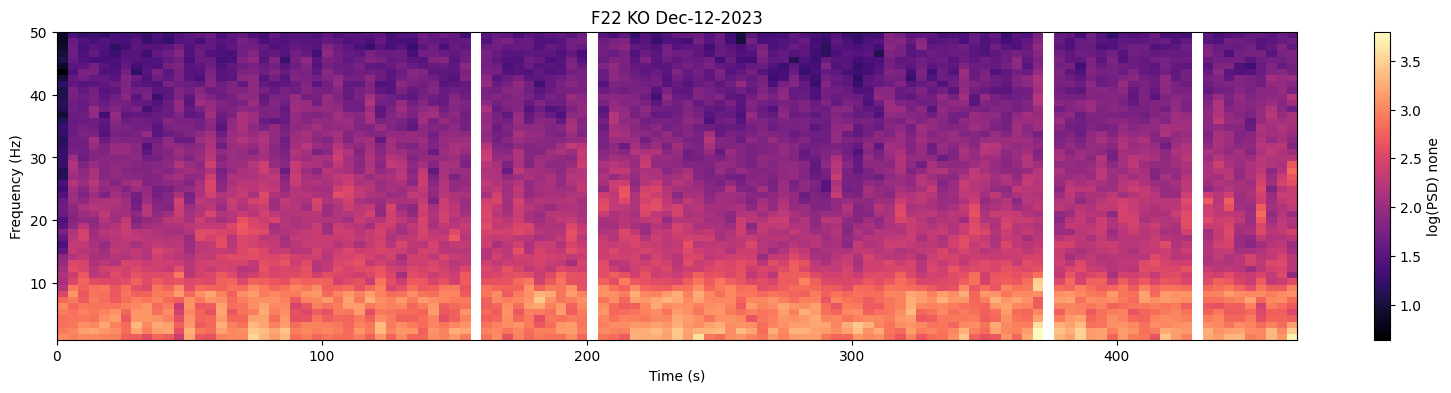

In [12]:
logger.setLevel(logging.WARNING)
ap = visualization.AnimalPlotter(war)
ap.plot_coherecorr_matrix(['isday'], bands=None, figsize=(16,5), cmap='viridis')
# ap.plot_coherecorr_diff(['isday'], bands=None, figsize=(16,5))
# ap.plot_linear_temporal(figsize=(20, 5), score_type='z', lw=1, channels=[0, 1])
# ap.plot_linear_temporal(['isday'], figsize=(20, 5), score_type='z', lw=1, channels=[0, 1, 2, 3])

# ap.plot_coherecorr_spectral(['isday'], figsize=(20, 5), score_type='center')

ap.plot_coherecorr_spectral(figsize=(20, 5), score_type='center')
ap.plot_psd_histogram(figsize=(10, 4), avg_channels=True, plot_type='loglog')
ap.plot_psd_spectrogram(figsize=(20, 4), mode='none')

In [13]:
logger.setLevel(logging.DEBUG)
wars = []
animal_ids = ['A5', 'A10', 'F22']
for i, animal_id in enumerate(animal_ids):
    war = visualization.WindowAnalysisResult.load_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())
    # logging.critical(war.result.iloc[0]['pcorr'])
    # war = war.filter_all()
    # logging.critical(war.result.iloc[0]['pcorr'])
    
    # wrangle = war.result.copy()
    # war.filter_all(bad_channels=['LMot', 'RBar'])
    wars.append(war)
    
ep = visualization.ExperimentPlotter(wars,
                                     exclude=['nspike', 'psdfrac', 'logrms', 'logampvar', 'logpsdtotal', 'lognspike', 'logpsdband', 'logpsdfrac'])


Channel names: 	['Intan Input (1)/PortB L Aud Ctx', 'Intan Input (1)/PortB L Vis Ctx', 'Intan Input (1)/PortB L Hipp', 'Intan Input (1)/PortB L Barrel', 'Intan Input (1)/PortB L Motor', 'Intan Input (1)/PortB R Motor', 'Intan Input (1)/PortB R Barrel', 'Intan Input (1)/PortB R Hipp', 'Intan Input (1)/PortB R Vis Ctx', 'Intan Input (1)/PortB R Aud Ctx']
Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']
2025-06-05 15:22:03,995 - WARNING - Intan Input (1)/PortC C-009 does not match name aliases. Assuming alias from number in channel name.
2025-06-05 15:22:03,996 - WARNING - Intan Input (1)/PortC C-010 does not match name aliases. Assuming alias from number in channel name.
2025-06-05 15:22:03,997 - WARNING - Intan Input (1)/PortC C-012 does not match name aliases. Assuming alias from number in channel name.
2025-06-05 15:22:03,998 - WARNING - Intan Input (1)/PortC C-014 does not match name aliases. Assuming alias from number in channe

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.concat_df_wars: pd.DataFrame = pd.concat(df_wars, axis=0, ignore_index=True) # TODO this raises a warning about df wars having columns that are none I think


In [14]:
# for feat in constants.LINEAR_FEATURE + ['psdband']:
#     logging.info(f'pulling {feat}')
#     df = ep._pull_timeseries_dataframe(feat, 'animal')
#     # display(df)
#     # ep.plot_boxplot_2(feat, ['genotype', 'animalday'], collapse_channels=False)
#     ep.plot_catplot(feat, 'animal', kind='violin')

# ep.plot_catplot('psdband', ['animal', 'isday', 'animalday'], 
#                 x='animal',
#                 col='isday',
#                 hue='band',
#                 kind='boxen',
#                 collapse_channels=False,
#                 catplot_params={'showfliers': False})

In [15]:
# for feat in ['cohere']:
#     logging.info(f'pulling {feat}')
#     df = ep._pull_timeseries_dataframe(feat, ['animal', 'isday'])
#     ep.plot_2d_feature_2(feat, ['animal', 'isday'], row='band')

2025-06-05 15:22:04,700 - DEBUG - groups: [('A10 KO Dec-13-2023', True), ('A5 WT Dec-12-2023', True), ('F22 KO Dec-12-2023', True)]
2025-06-05 15:22:04,740 - DEBUG - vals.shape: (1917, 5, 10, 10)
2025-06-05 15:22:04,742 - DEBUG - vals.shape: (1917, 5, 10, 10)


2025-06-05 15:22:05,264 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-06-05 15:22:05,265 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-06-05 15:22:05,276 - DEBUG - vals.shape: (117, 5, 10, 10)
2025-06-05 15:22:05,283 - DEBUG - vals.shape: (117, 5, 10, 10)
2025-06-05 15:22:06,009 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fc004726350>
2025-06-05 15:22:06,044 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fc0281196f0>
2025-06-05 15:22:06,080 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fc0280aba60>
2025-06-05 15:22:06,521 - DEBUG - groups: ['A10 KO Dec-13-2023', 'A5 WT Dec-12-2023', 'F22 KO Dec-12-2023']
2025-06-05 15:22:06,529 - DEBUG - vals.shape: (1917, 5, 10, 10)
2025-06-05 15:22:06,531 - DEBUG - vals.shape: (1917, 5, 10, 10)
2025-06-05 15:22:06,842 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-06-05 15:22:06,844 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-06-05 15:22:06,850 - DEBUG - vals.shape: (117, 5, 10, 10)
2025-06-05 15:22:06,852 - D

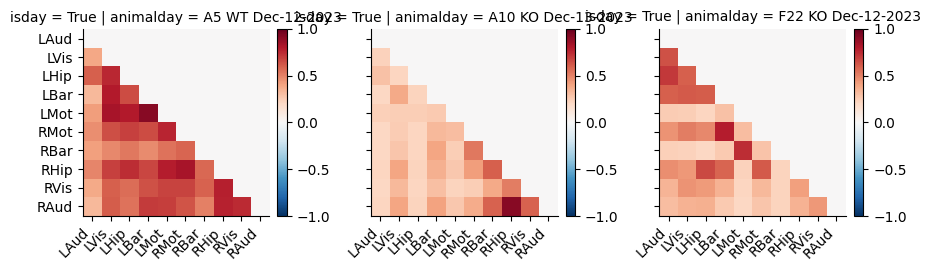

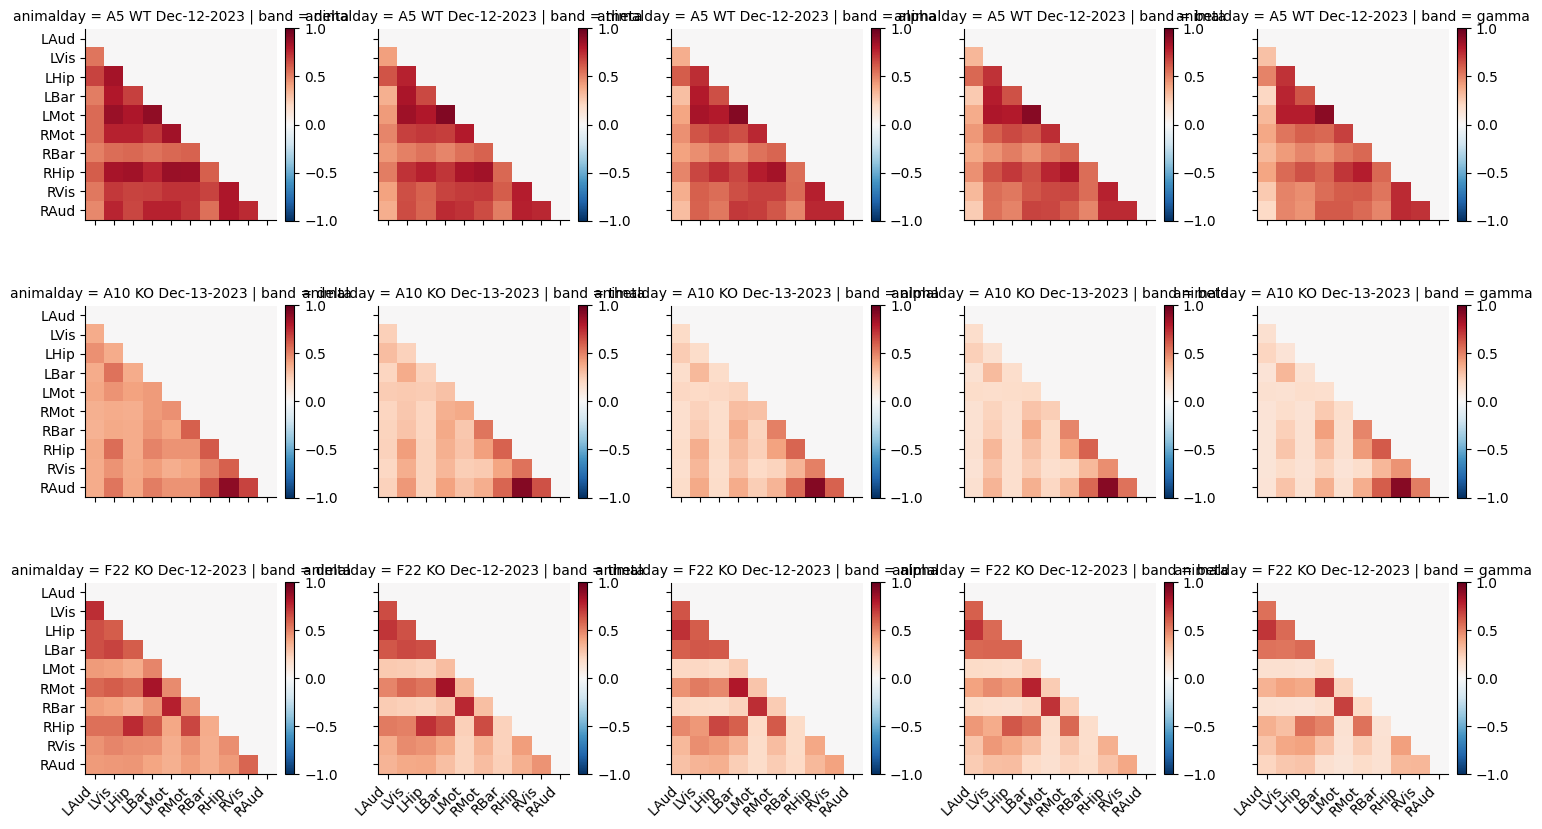

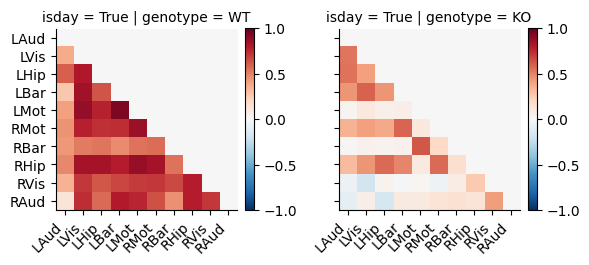

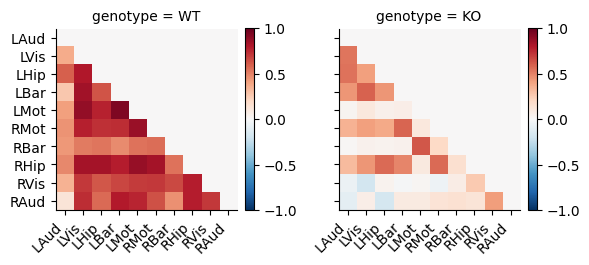

In [16]:
ep.plot_heatmap('cohere', groupby=['animalday', 'isday'])
ep.plot_heatmap('cohere', groupby='animalday', col='band', row='animalday')

ep.plot_heatmap('pcorr', groupby=['genotype', 'isday'])
ep.plot_heatmap('pcorr', groupby='genotype')

2025-06-05 15:27:56,293 - DEBUG - groups: ['KO', 'WT']
2025-06-05 15:27:56,294 - DEBUG - vals.shape: (1917, 10)
2025-06-05 15:27:56,299 - DEBUG - vals.shape: (31, 10)
2025-06-05 15:27:56,300 - DEBUG - vals.shape: (117, 10)
2025-06-05 15:27:56,681 - DEBUG - groups: ['KO', 'WT']
2025-06-05 15:27:56,683 - DEBUG - vals.shape: (1917,)
2025-06-05 15:27:56,685 - DEBUG - vals.shape: (31,)
2025-06-05 15:27:56,687 - DEBUG - vals.shape: (117,)


UnboundLocalError: local variable 'boxprops' referenced before assignment

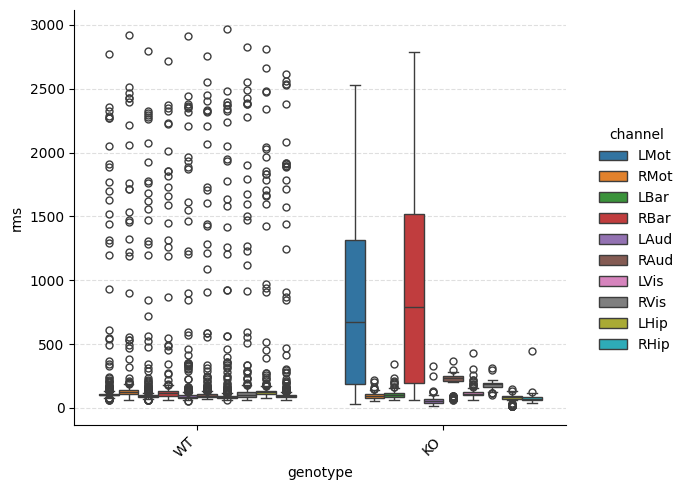

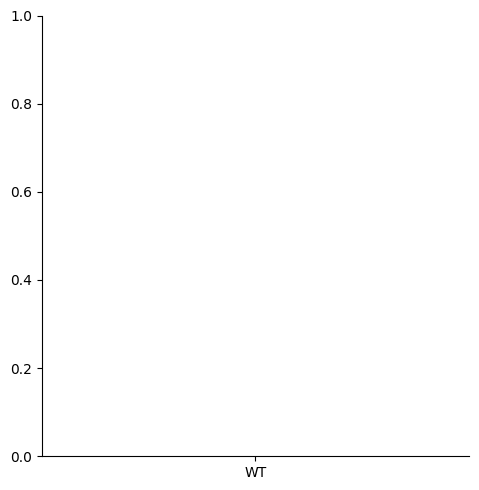

In [18]:
for feature in constants.LINEAR_FEATURES:
    if feature in ['nspike', 'psdfrac', 'logrms', 'logampvar', 'logpsdtotal', 'lognspike', 'logpsdband', 'logpsdfrac']:
        print(f"Skipping feature {feature}")
        continue
    for kind in ['box', 'violin']:
        for groupby in ['genotype', ['genotype', 'isday']]:
            for collapse in [False, True]:
                ep.plot_catplot(feature, groupby=groupby, kind=kind, collapse_channels=collapse)
for kind in ['box', 'violin']:
    ep.plot_catplot('psdband', groupby=['genotype', 'isday'], 
                    x='genotype',
                    col='isday',
                    hue='band',
                    kind=kind, collapse_channels=True)
    ep.plot_catplot('psdband', groupby=['genotype'], 
                    x='genotype',
                    hue='band',
                    kind=kind, collapse_channels=True)

2025-06-03 20:08:16,463 - DEBUG - groups: ['A10', 'F22']
2025-06-03 20:08:16,464 - DEBUG - vals.shape: (31, 10)
2025-06-03 20:08:16,467 - DEBUG - vals.shape: (117, 10)


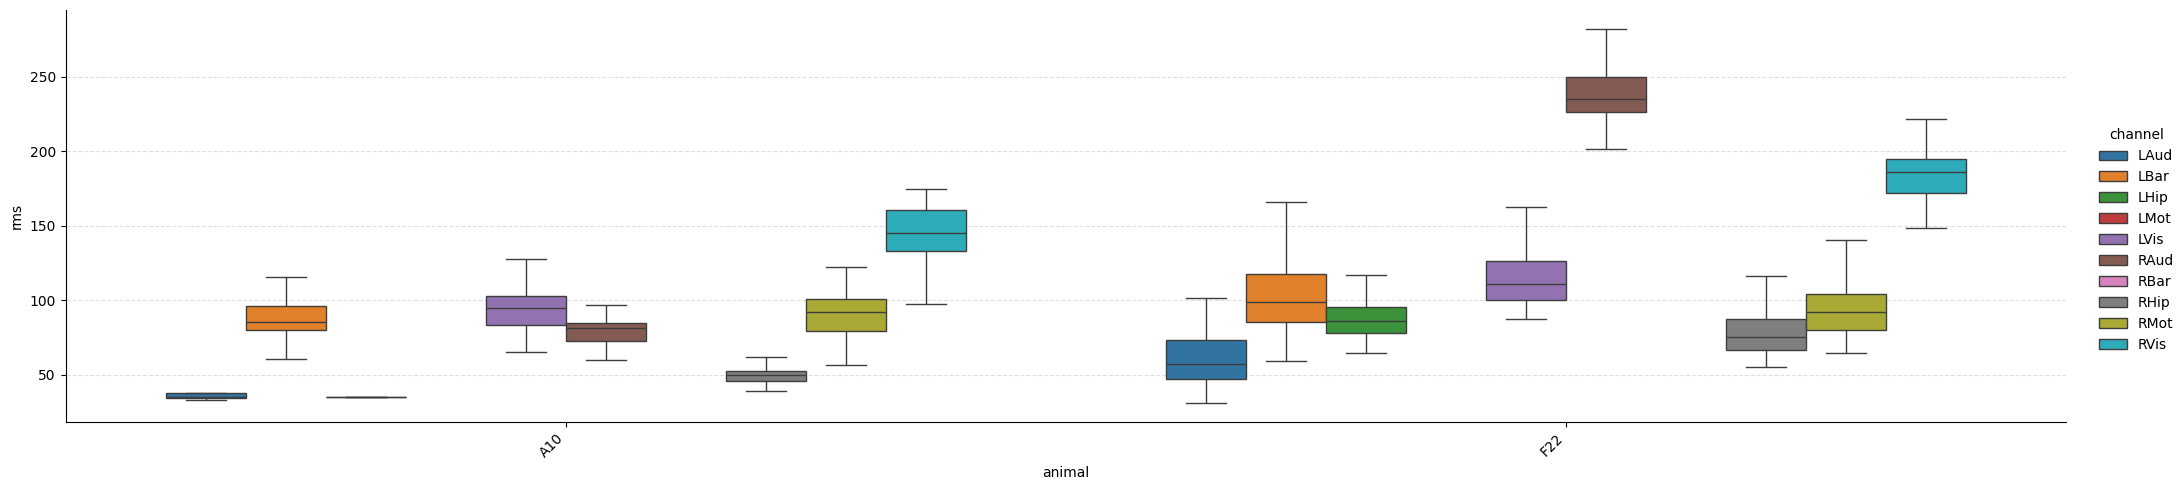

In [18]:
ep.plot_catplot('rms', groupby='animal', kind='box', catplot_params={'showfliers': False, 'aspect': 4})

2025-06-03 20:08:17,084 - DEBUG - groups: ['A10', 'F22']
2025-06-03 20:08:17,089 - DEBUG - vals.shape: (31, 10, 10)
2025-06-03 20:08:17,093 - DEBUG - vals.shape: (117, 10, 10)
2025-06-03 20:08:17,235 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2146658df0>
2025-06-03 20:08:17,262 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f21466f8d30>


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)


2025-06-03 20:08:17,464 - DEBUG - groups: ['A10', 'F22']
2025-06-03 20:08:17,466 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-06-03 20:08:17,467 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-06-03 20:08:17,472 - DEBUG - vals.shape: (117, 5, 10, 10)
2025-06-03 20:08:17,473 - DEBUG - vals.shape: (117, 5, 10, 10)
2025-06-03 20:08:18,104 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2145f6e5f0>
2025-06-03 20:08:18,132 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2145fbfac0>
2025-06-03 20:08:18,161 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2145e21f00>
2025-06-03 20:08:18,188 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2145e6f940>
2025-06-03 20:08:18,215 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2145ecdba0>
2025-06-03 20:08:18,242 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2145d1fdc0>
2025-06-03 20:08:18,269 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2145d

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix

2025-06-03 20:08:18,301 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2145dd3640>
2025-06-03 20:08:18,697 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2146e43070>
2025-06-03 20:08:18,723 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f214723b190>


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)


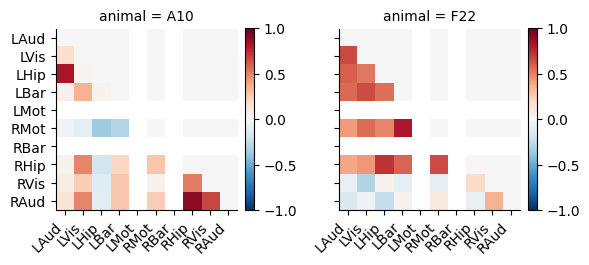

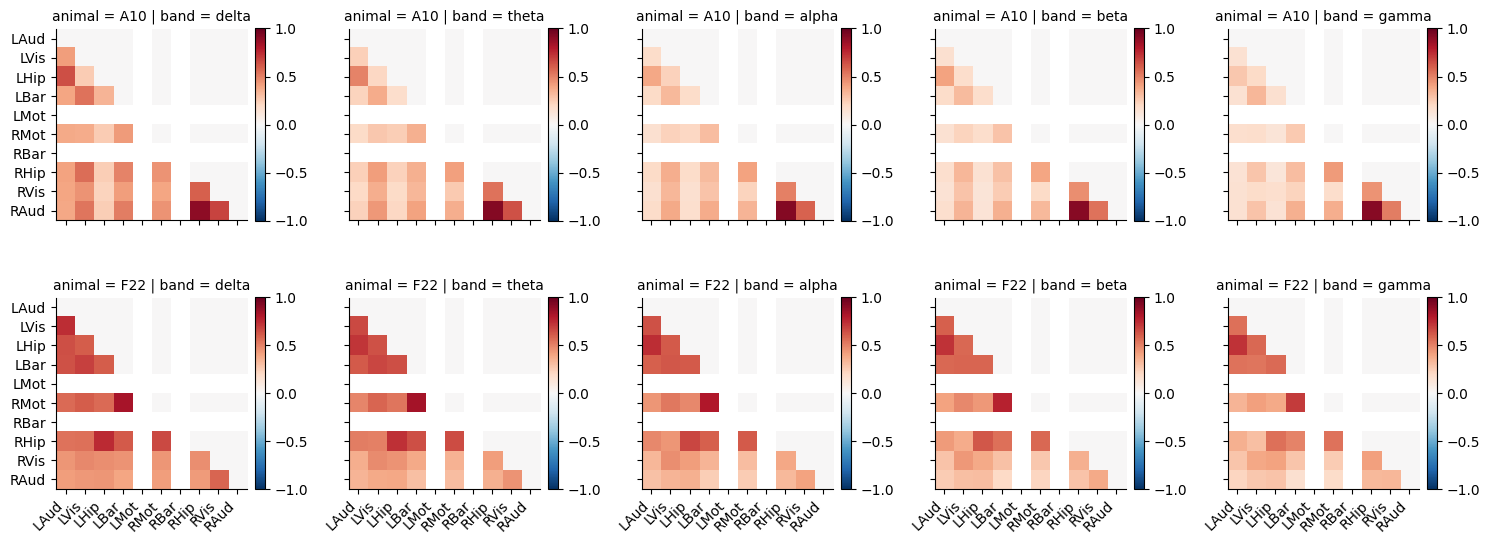

In [19]:
ep.plot_heatmap('pcorr', groupby='animal')
ep.plot_heatmap('cohere', groupby='animal', col='band', row='animal')

In [20]:
logger.setLevel(logging.DEBUG)

In [21]:
for e in sar:
    e.convert_to_mne(chunk_len=1440)
    e.save_fif_and_json(Path(f'./test-mnes/{e.animal_day}').resolve(), overwrite=True)

NameError: name 'sar' is not defined

In [17]:
reconstruct_sas = visualization.SpikeAnalysisResult.load_fif_and_json('./test-mnes/A5 WT Dec-12-2023')
mne_obj = reconstruct_sas.result_mne

Opening raw data file test-mnes/A5 WT Dec-12-2023/A5-WT-A5 WT Dec-12-2023-raw.fif...
    Reading extended channel information
Isotrak not found
    Range : 0 ... 40067758 =      0.000 ... 40067.758 secs
Ready.
2025-03-21 21:23:35,173 - INFO - Channel names: 	['Intan Input (1)/PortB L Aud Ctx', 'Intan Input (1)/PortB L Vis Ctx', 'Intan Input (1)/PortB L Hipp', 'Intan Input (1)/PortB L Barrel', 'Intan Input (1)/PortB L Motor', 'Intan Input (1)/PortB R Motor', 'Intan Input (1)/PortB R Barrel', 'Intan Input (1)/PortB R Hipp', 'Intan Input (1)/PortB R Vis Ctx', 'Intan Input (1)/PortB R Aud Ctx']
2025-03-21 21:23:35,174 - INFO - Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


Used Annotations descriptions: [np.str_('Intan Input (1)/PortB L Aud Ctx'), np.str_('Intan Input (1)/PortB L Barrel'), np.str_('Intan Input (1)/PortB L Hipp'), np.str_('Intan Input (1)/PortB L Motor'), np.str_('Intan Input (1)/PortB L Vis Ctx'), np.str_('Intan Input (1)/PortB R Aud Ctx'), np.str_('Intan Input (1)/PortB R Barrel'), np.str_('Intan Input (1)/PortB R Hipp'), np.str_('Intan Input (1)/PortB R Motor'), np.str_('Intan Input (1)/PortB R Vis Ctx')]


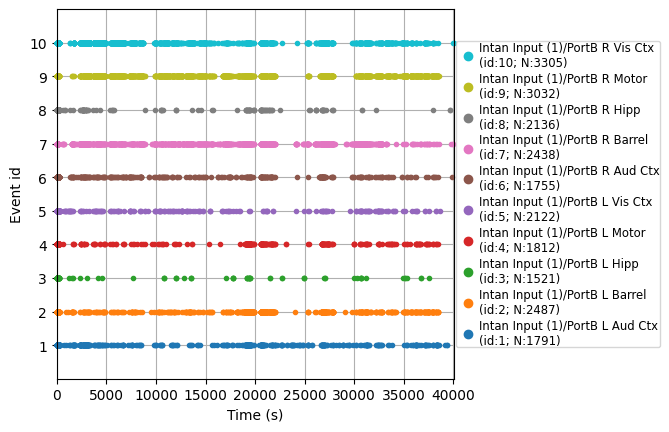

In [18]:
logger.setLevel(logging.WARNING)
events, event_id = mne.events_from_annotations(raw=mne_obj)
fig = mne.viz.plot_events(events, sfreq=mne_obj.info['sfreq'], first_samp=mne_obj.first_samp, event_id=event_id)